In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import random


conv_dropout_p = 0.75




DATA_DIRS = [
    (0.0, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.0'),
    (0.2, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.2'),
    (0.4, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.4'),
    (0.6, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.6'),
    (0.8, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.8'),
    (0.9, f'results_010_gn_lang_classification__spectrogram_dropout_0.75__fc_dropout_0.9'),
]


#DATA_DIRS = [
#    (0.4, 'results_008_gn_lang_classification__dropout_0.7__fc_dropout_0.4'),
#    (0.5, 'results_008_gn_lang_classification__dropout_0.7__fc_dropout_0.5'),
#]



#DATA_DIRS = [
#    (0.5, 'results_008_gn_lang_classification__dropout_0.5__fc_dropout_0.5'),
#]


random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#2ca02c"] # "#7f7f7f", "#1f77b4"

n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
def load_data(data_dir):
    data_frames = {}

    variable_names = []

    for model_path in Path(data_dir).iterdir():
        if not model_path.is_dir():
            continue

        if "NN" not in str(model_path):
            continue

        model_name = model_path.stem
        print(f"MODEL: {model_name}")
        fold_names = []

        data_frames[model_name] = {}

        for p in Path(model_path).iterdir():
            if not p.suffixes or p.suffixes[-1] != '.csv':
                continue
            fold_name = p.stem
            fold_names.append(fold_name)
            data_frames[model_name][fold_name] = pd.read_csv(p)
            variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
        for fold_name in sorted(fold_names):
            print(f"\t{fold_name}")

    print(f"VARIABLES")        
    for variable_name in sorted(set(variable_names)):
        print(f"\t{variable_name}")
    
    return data_frames

    

In [3]:
def get_variable_stats(data_frames, model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [4]:
def plot_comparative_variables(ax, data_frames, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(data_frames, model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [5]:
def plot_results(data_frames, model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index],
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [6]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [7]:
model_names = ['LangIdCNN_Mean2_FCD_Spectrogram']

variables_and_sample_sizes = [
    #('train_loss', n_train),
    #('test_loss', n_test),
    ('train_acc', 10),
    ('test_acc', 10),
    #('test_acc_gender_male', n_test),
    #('test_acc_gender_female', n_test),
    #('test_acc_language_maninka', n_test),
    #('test_acc_language_pular', n_test),
    #('test_acc_language_susu', n_test)
]


# Best epoch summaries

In [8]:
def plot_summary_results(data_frames, model_names, variables_and_sample_sizes, compared_features, plot_title):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(data_frames, model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 10
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }
#88290d

#b44f0f

#dc790b

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    

    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        f_name = feature_name.replace(
            "retrained-wav2vec_features-z", "OUR  Latent"
        ).replace(
            "retrained-wav2vec_features-c", "OUR  Context"
        ).replace(
            "wav2vec_features-z", "BSLN  Latent"
        ).replace(
            "wav2vec_features-c", "BSLN  Context"
        )
        
        m_name = model_name.replace('LangId','')# .replace("1", "")

        label_str = f"{f_name} - {m_name}"

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i], test_acc_label_str, color='white', fontsize="large")
        
        
        ax.text(0.01, test_y_male_pos[i]-0.3, "male", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, "female", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, "susu", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, "maninka", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, "pular", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN ACC", "TEST ACC", "TEST ACC (Male)", "TEST ACC (Female)", "TEST ACC (Susu)", "TEST ACC (Maninka)", "TEST ACC (Pular)"])
        ax.grid(True)
        plt.title(plot_title)

        
        


In [9]:
series_by_dropout_p = {}

for dropout_p, data_dir in DATA_DIRS:
    data_frames = load_data(data_dir)
    compared_features = ['spectrogram']
    
    for model_name in model_names:
        variables = [t[0] for t in variables_and_sample_sizes]
        sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

        series_means = {v:[] for v in variables}
        series_sems = {v:[] for v in variables}
        series_mins = {v:[] for v in variables}
        series_maxes = {v:[] for v in variables}

        series_labels = {v:[] for v in variables}

        for variable in variables:
            for feature_prefix in compared_features:
                sample_size = sample_sizes_by_variable[variable]
                for model_name in model_names:
                    stats = get_variable_stats(data_frames, model_name, feature_prefix, variable, sample_size)
                    series_means[variable].append(stats['best_epoch_mean'])
                    series_sems[variable].append(stats['best_epoch_sem'])
                    series_mins[variable].append(stats['best_epoch_min'])
                    series_maxes[variable].append(stats['best_epoch_max'])
                    series_labels[variable].append((model_name, feature_prefix))
                    
                    
        series_by_dropout_p[dropout_p] = {
            "series_means": series_means,
            "series_sems": series_sems,
            "series_mins": series_mins,
            "series_maxes": series_maxes,
            "series_labels": series_labels
        }

MODEL: LangIdCNN_Mean2_FCD_Spectrogram
	spectrogram_0
	spectrogram_1
	spectrogram_2
	spectrogram_3
	spectrogram_4
	spectrogram_5
	spectrogram_6
	spectrogram_7
	spectrogram_8
	spectrogram_9
VARIABLES
	epoch
	test_acc
	test_acc_channel_music
	test_acc_channel_noise
	test_acc_channel_telephone
	test_acc_gender_female
	test_acc_gender_male
	test_acc_language_maninka
	test_acc_language_pular
	test_acc_language_susu
	test_acc_speaker_count_multiple
	test_acc_speaker_count_single
	test_acc_utterance_multilingual
	test_acc_utterance_verbal_nod
	test_loss
	test_n
	test_n_channel_music
	test_n_channel_noise
	test_n_channel_telephone
	test_n_gender_female
	test_n_gender_male
	test_n_language_maninka
	test_n_language_pular
	test_n_language_susu
	test_n_speaker_count_multiple
	test_n_speaker_count_single
	test_n_utterance_multilingual
	test_n_utterance_verbal_nod
	train_acc
	train_acc_channel_music
	train_acc_channel_noise
	train_acc_channel_telephone
	train_acc_gender_female
	train_acc_gender_male

In [10]:
series_by_dropout_p

{0.0: {'series_means': {'train_acc': [0.5666666666666667],
   'test_acc': [0.6000000000000001]},
  'series_sems': {'train_acc': [0.06065451036045475],
   'test_acc': [0.02803644486356455]},
  'series_mins': {'train_acc': [0.2549019607843137],
   'test_acc': [0.4848484848484849]},
  'series_maxes': {'train_acc': [0.7843137254901961],
   'test_acc': [0.7272727272727273]},
  'series_labels': {'train_acc': [('LangIdCNN_Mean2_FCD_Spectrogram',
     'spectrogram')],
   'test_acc': [('LangIdCNN_Mean2_FCD_Spectrogram', 'spectrogram')]}},
 0.2: {'series_means': {'train_acc': [0.515686274509804],
   'test_acc': [0.5727272727272728]},
  'series_sems': {'train_acc': [0.05628851366373867],
   'test_acc': [0.02285820868563164]},
  'series_mins': {'train_acc': [0.21568627450980396],
   'test_acc': [0.4848484848484849]},
  'series_maxes': {'train_acc': [0.7843137254901961],
   'test_acc': [0.6666666666666666]},
  'series_labels': {'train_acc': [('LangIdCNN_Mean2_FCD_Spectrogram',
     'spectrogram')],

In [11]:
trained_models = list(series_by_dropout_p.items())[0][1]['series_labels']['train_acc']
    
dropout_rates = []
test_accuracies_by_tm = {tm: [] for tm in trained_models}
test_accuracy_sems_by_tm = {tm: [] for tm in trained_models}

train_accuracies_by_tm = {tm: [] for tm in trained_models}
train_accuracy_sems_by_tm = {tm: [] for tm in trained_models}

for dropout_rate in sorted(series_by_dropout_p.keys()):
    dropout_rates.append(dropout_rate)
    for index in range(len(trained_models)):
        tm = trained_models[index]
        train_acc = series_by_dropout_p[dropout_rate]['series_means']['train_acc'][index]
        train_acc_sem = series_by_dropout_p[dropout_rate]['series_sems']['train_acc'][index]
        test_acc = series_by_dropout_p[dropout_rate]['series_means']['test_acc'][index]
        test_acc_sem = series_by_dropout_p[dropout_rate]['series_sems']['test_acc'][index]
        
        train_accuracies_by_tm[tm].append(train_acc)
        train_accuracy_sems_by_tm[tm].append(train_acc_sem)
        
        test_accuracies_by_tm[tm].append(test_acc)
        test_accuracy_sems_by_tm[tm].append(test_acc_sem)
        
        
        
list_dict_to_np = lambda d: {k: np.array(v) for k,v in d.items()}

test_accuracies_by_tm = list_dict_to_np(test_accuracies_by_tm)
test_accuracy_sems_by_tm = list_dict_to_np(test_accuracy_sems_by_tm)
train_accuracies_by_tm = list_dict_to_np(train_accuracies_by_tm)
train_accuracy_sems_by_tm = list_dict_to_np(train_accuracy_sems_by_tm)


[('LangIdCNN_Mean2_FCD_Spectrogram', 'spectrogram')]


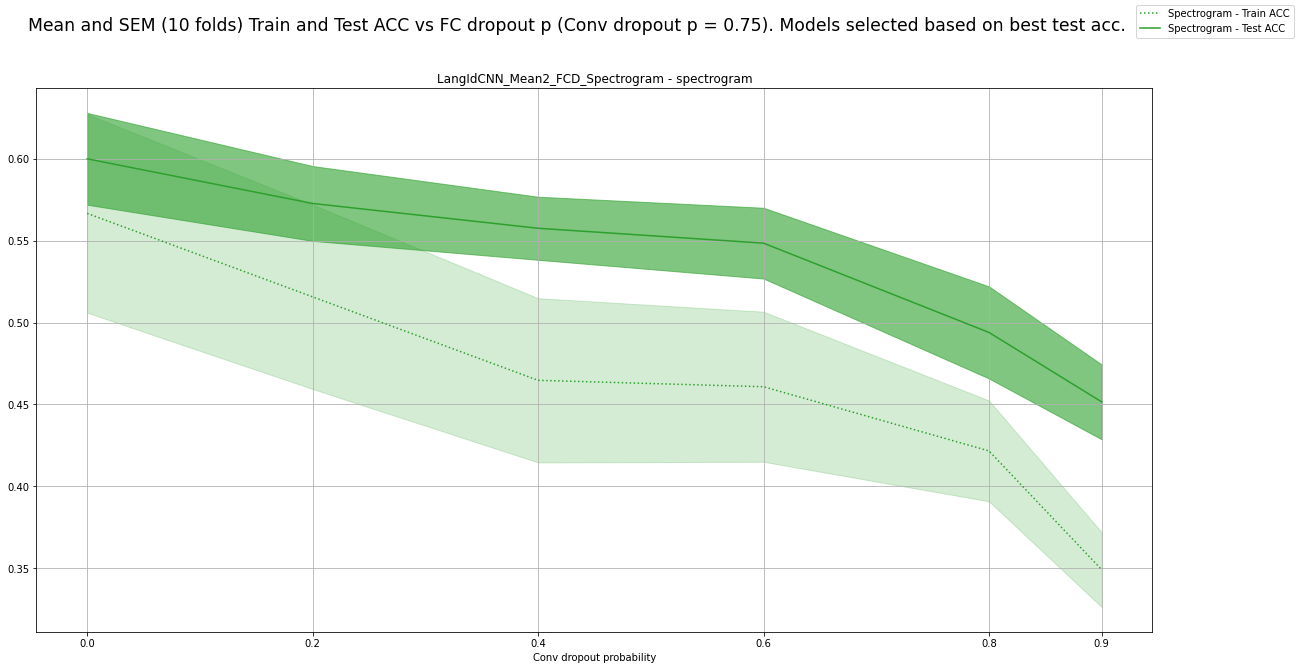

In [12]:
#plt.figure(figsize=(15, 15))

models = sorted({tm[0] for tm in trained_models})
print(trained_models)
#feature_types = sorted({tm[1].split("_")[1] for tm in trained_models})
feature_types = sorted({tm[1] for tm in trained_models})

fig, ax = plt.subplots(len(feature_types), len(models), figsize=(20, 10), sharex=True, sharey=True)


for fti, feature_type in enumerate(feature_types):
    for mi, model in enumerate(models):
        legend = []
        compared_tms = [tm for tm in trained_models if tm[0]==model and feature_type in tm[1]]
        for tmi, tm in enumerate(compared_tms):
            ax = np.array(ax).reshape(len(feature_types), len(models))
            ax[fti, mi].plot(dropout_rates, train_accuracies_by_tm[tm], color=COLORS[tmi], linestyle=":")
            ax[fti, mi].fill_between(
                x=dropout_rates, 
                y1=train_accuracies_by_tm[tm] - train_accuracy_sems_by_tm[tm], 
                y2=train_accuracies_by_tm[tm] + train_accuracy_sems_by_tm[tm], 
                color=COLORS[tmi],
                alpha=0.2
            )
            
            ax[fti, mi].plot(dropout_rates, test_accuracies_by_tm[tm], color=COLORS[tmi])
            ax[fti, mi].fill_between(
                x=dropout_rates, 
                y1=test_accuracies_by_tm[tm] - test_accuracy_sems_by_tm[tm], 
                y2=test_accuracies_by_tm[tm] + test_accuracy_sems_by_tm[tm], 
                color=COLORS[tmi],
                alpha=0.6
            )
            
            ax[fti, mi].set_xticks(dropout_rates)
            
            ax[fti, mi].set_xlabel("Conv dropout probability")
            #ax[fti, mi].set_ylabel("accuracy")
            
            #legend.append(f"{'OURS' if 'retrained' in tm[1] else 'BSLN'} - Train ACC")
            #legend.append(f"{'OURS' if 'retrained' in tm[1] else 'BSLN'} - Test ACC")
            
            legend.append(f"Spectrogram - Train ACC")
            legend.append(f"Spectrogram - Test ACC")
            
        # ax[fti, mi].legend(legend)
        ax[fti, mi].set_title(f"{model} - {feature_type}")
        ax[fti, mi].grid(True)

fig.suptitle(
    f"Mean and SEM (10 folds) Train and Test ACC vs FC dropout p (Conv dropout p = {conv_dropout_p}). Models selected based on best test acc.",
    fontsize='xx-large'
)
fig.legend(legend)

In [13]:
feature_types

['spectrogram']